In [1]:
import json

import matplotlib.pyplot as plt # keep this import for CI to work

from muutils.zanj import ZANJ
from maze_transformer.generation.lattice_maze import SolvedMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.dataset.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.dataset.maze_dataset_configs import MAZE_DATASET_CONFIGS
from maze_transformer.dataset.plot_dataset import plot_dataset_mazes, print_dataset_mazes
from maze_transformer.utils.utils import pprint_summary

print(MAZE_DATASET_CONFIGS.keys())

LOCAL_DATA_PATH: str = "../data/maze_dataset/"

dict_keys(['test-g3-n5-a_dfs-h24736', 'demo_small-g3-n100-a_dfs-h51648', 'demo-g6-n10K-a_dfs-h33999'])


you should always see `test-g3-n5-a_dfs-h43920` in the list of available dataset configs

In [2]:
zanj: ZANJ = ZANJ(external_list_threshold=256)
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=3,
	n_mazes=32,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)

print(cfg.to_fname())

test-g3-n32-a_dfs-h40850


In [3]:
dataset: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False, # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

generating dataset...


generating & solving mazes: 100%|██████████| 32/32 [00:00<00:00, 1142.82maze/s]

saving dataset to ..\data\maze_dataset\test-g3-n32-a_dfs-h40850.zanj
Got dataset test with 32 items. output.cfg.to_fname() = 'test-g3-n32-a_dfs-h40850'


In [4]:
dataset_cpy: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=True,
	do_generate=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
)


loading dataset from ../data/maze_dataset/test-g3-n32-a_dfs-h40850.zanj
Got dataset test with 32 items. output.cfg.to_fname() = 'test-g3-n32-a_dfs-h40850'


In [5]:
assert dataset.cfg == dataset_cpy.cfg
print(len(dataset), len(dataset_cpy))
print(dataset_cpy[0])
assert all(x == y for x,y in zip(dataset, dataset_cpy))

32 32
SolvedMaze(connection_list=array([[[ True,  True,  True],
        [ True, False,  True],
        [False, False, False]],

       [[False, False, False],
        [False,  True, False],
        [ True,  True, False]]]), generation_meta={'func_name': 'gen_dfs', 'grid_shape': array([3, 3]), 'start_coord': array([0, 1]), 'n_accessible_cells': 9, 'max_tree_depth': 18, 'fully_connected': True, 'visited_cells': [[0, 1], [1, 2], [2, 1], [0, 0], [1, 1], [2, 0], [0, 2], [2, 2], [1, 0]]}, start_pos=array([1, 2]), end_pos=array([0, 0]), solution=array([[1, 2],
       [2, 2],
       [2, 1],
       [2, 0],
       [1, 0],
       [0, 0]]))


In [6]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset) = }")
print(f"{len(dataset_filtered) = }")

len(dataset) = 32
len(dataset_filtered) = 27


(<Figure size 1500x500 with 27 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >], dtype=object))

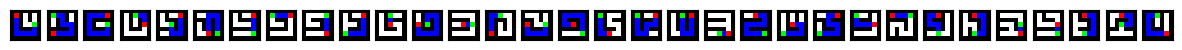

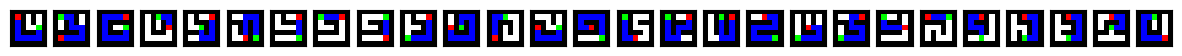

In [7]:
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered)


In [8]:
print(json.dumps(dataset_filtered.cfg.serialize()["applied_filters"], indent=2))
print(f"{MazeDataset._FILTER_NAMESPACE = }")

[
  {
    "name": "path_length",
    "args": [],
    "kwargs": {
      "min_length": 3
    }
  }
]
MazeDataset._FILTER_NAMESPACE = <class 'maze_transformer.dataset.maze_dataset.MazeDatasetFilters'>


In [9]:
dataset_filtered_from_scratch: MazeDataset = MazeDataset.from_config(
	dataset_filtered.cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False,
)

generating dataset...


generating & solving mazes: 100%|██████████| 27/27 [00:00<00:00, 932.46maze/s]

Got dataset test with 24 items. output.cfg.to_fname() = 'test-g3-n24-a_dfs-h49178'


(<Figure size 1500x500 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

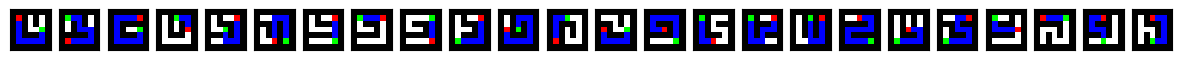

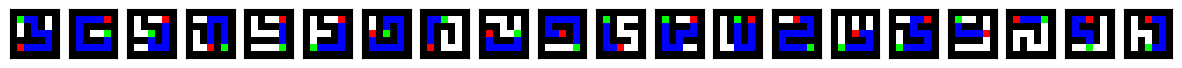

In [10]:
plot_dataset_mazes(dataset_filtered_from_scratch)
dataset_filtered_nodupe = dataset_filtered_from_scratch.filter_by.remove_duplicates()
plot_dataset_mazes(dataset_filtered_nodupe)


(<Figure size 1500x500 with 7 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >], dtype=object))

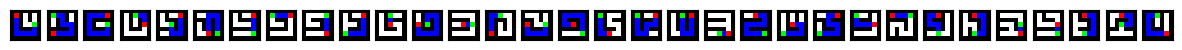

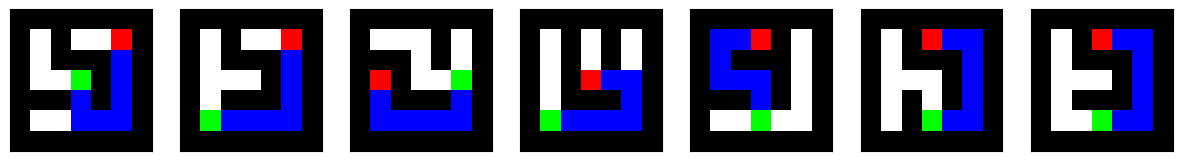

In [11]:
dataset_filtered_custom: MazeDataset = dataset.custom_maze_filter(
	lambda m, p: len(m.solution) == p,
	p=5,
)
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered_custom)

In [12]:
dataset_with_meta = dataset.filter_by.collect_generation_meta()

pprint_summary(dataset_with_meta.serialize()['generation_metadata_collected'])

{
  "func_name": {
    "gen_dfs": 32
  },
  "grid_shape": {
    "(3, 3)": 32
  },
  "start_coord": {
    "(0, 1)": 9,
    "(1, 0)": 7,
    "(1, 1)": 6,
    "(0, 0)": 10
  },
  "n_accessible_cells": {
    "9": 32
  },
  "max_tree_depth": {
    "18": 32
  },
  "fully_connected": {
    "True": 32
  },
  "visited_cells": {
    "(0, 1)": 32,
    "(1, 2)": 32,
    "(2, 1)": 32,
    "(0, 0)": 32,
    "(1, 1)": 32,
    "(2, 0)": 32,
    "(0, 2)": 32,
    "(2, 2)": 32,
    "(1, 0)": 32
  }
}


In [13]:
dataset_not_fully_connected = MazeDataset.from_config(
	MazeDatasetConfig(
		name="test_disconnected",
		grid_n=10,
		n_mazes=32,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(
			n_accessible_cells = 70,
        	max_tree_depth = 15,
		),
	),
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
)

generating dataset...


generating & solving mazes: 100%|██████████| 32/32 [00:00<00:00, 359.58maze/s]

saving dataset to ..\data\maze_dataset\test_disconnected-g10-n32-a_dfs-h71823.zanj


Got dataset test_disconnected with 32 items. output.cfg.to_fname() = 'test_disconnected-g10-n32-a_dfs-h71823'


(<Figure size 1500x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

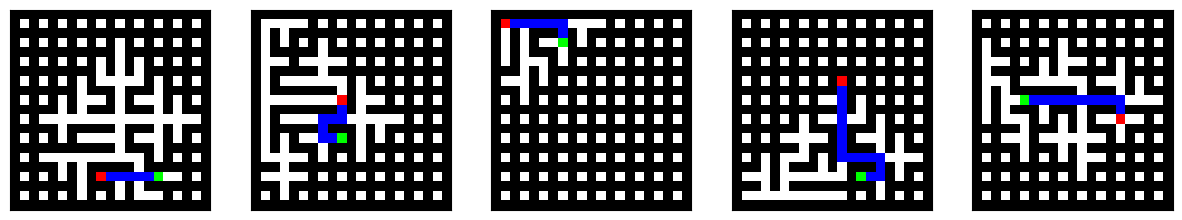

In [14]:
plot_dataset_mazes(dataset_not_fully_connected, 5)

In [15]:
STANDARD_KWARGS_FROM_CONFIG: dict = dict(
    do_download=False,
	load_local=False,
	do_generate=True,
	save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
)

In [16]:
dataset_hallway: MazeDataset = MazeDataset.from_config(
	MazeDatasetConfig(
		name="test_hallway",
		grid_n=8,
		n_mazes=5,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(
			n_accessible_cells = 70,
        	max_tree_depth = 15,
            do_forks = False,
		),
	),
	**STANDARD_KWARGS_FROM_CONFIG,
)

generating dataset...


generating & solving mazes: 100%|██████████| 5/5 [00:00<00:00, 998.41maze/s]

saving dataset to ..\data\maze_dataset\test_hallway-g8-n5-a_dfs-h54072.zanj
Got dataset test_hallway with 5 items. output.cfg.to_fname() = 'test_hallway-g8-n5-a_dfs-h54072'


(<Figure size 1500x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

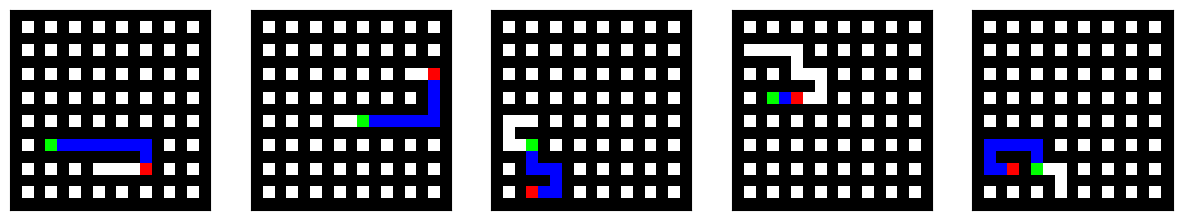

In [17]:
plot_dataset_mazes(dataset_hallway)

In [18]:
dataset_perc: MazeDataset = MazeDataset.from_config(
	MazeDatasetConfig(
		name="test_perc",
		grid_n=8,
		n_mazes=5,
		maze_ctor=LatticeMazeGenerators.gen_percolation,
        maze_ctor_kwargs=dict(p=0.5),
	),
	**STANDARD_KWARGS_FROM_CONFIG,
)

generating dataset...


generating & solving mazes: 100%|██████████| 5/5 [00:00<00:00, 357.05maze/s]

saving dataset to ..\data\maze_dataset\test_perc-g8-n5-a_percolation-h89547.zanj
Got dataset test_perc with 5 items. output.cfg.to_fname() = 'test_perc-g8-n5-a_percolation-h89547'


(<Figure size 1500x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

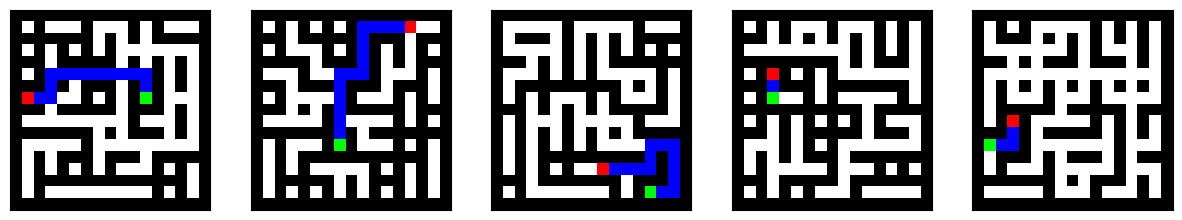

In [19]:
plot_dataset_mazes(dataset_perc)

In [20]:
dataset_dfs_perc: MazeDataset = MazeDataset.from_config(
	MazeDatasetConfig(
		name="test_dfs_perc",
		grid_n=8,
		n_mazes=5,
		maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,
        maze_ctor_kwargs=dict(p=0.2),
	),
	**STANDARD_KWARGS_FROM_CONFIG,
)

generating dataset...


generating & solving mazes: 100%|██████████| 5/5 [00:00<00:00, 74.63maze/s]

saving dataset to ..\data\maze_dataset\test_dfs_perc-g8-n5-a_dfs_percolation-h27505.zanj
Got dataset test_dfs_perc with 5 items. output.cfg.to_fname() = 'test_dfs_perc-g8-n5-a_dfs_percolation-h27505'


(<Figure size 1500x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

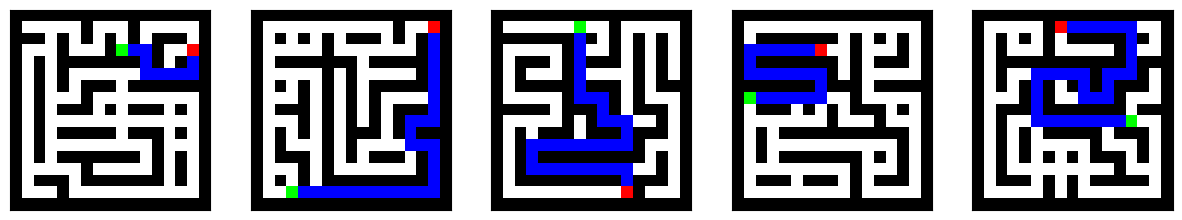

In [21]:
plot_dataset_mazes(dataset_dfs_perc)

In [22]:
for ds in [dataset_not_fully_connected, dataset_hallway, dataset_perc, dataset_dfs_perc]:
	print(f"{ds.cfg.name = }")
	pprint_summary(ds.filter_by.collect_generation_meta().serialize()['generation_metadata_collected'])

ds.cfg.name = 'test_disconnected'
{
  "func_name": {
    "gen_dfs": 32
  },
  "grid_shape": {
    "(10, 10)": 32
  },
  "start_coord": {
    "(6, 3)": 1,
    "(4, 1)": 1,
    "(2, 0)": 1,
    "(7, 4)": 1,
    "(5, 3)": 1,
    "(5, 6)": 1,
    "(8, 3)": 1,
    "(8, 2)": 1,
    "(2, 5)": 2,
    "(2, 7)": 1,
    "(5, 5)": 1,
    "(2, 4)": 2,
    "(7, 3)": 1,
    "(8, 6)": 1,
    "(8, 1)": 1,
    "(3, 5)": 2,
    "(0, 4)": 2,
    "(2, 1)": 1,
    "(8, 5)": 1,
    "(1, 2)": 1,
    "(7, 1)": 1,
    "(1, 3)": 1,
    "(1, 7)": 1,
    "(2, 3)": 1,
    "(3, 0)": 1,
    "(2, 2)": 1,
    "(5, 1)": 1,
    "(1, 0)": 1
  },
  "n_accessible_cells": {
    "70": 32
  },
  "max_tree_depth": {
    "15": 32
  },
  "fully_connected": {
    "False": 32
  },
  "visited_cells": {
    "(3, 4)": 22,
    "(4, 3)": 23,
    "(3, 7)": 10,
    "(5, 4)": 24,
    "(4, 6)": 18,
    "(5, 1)": 15,
    "(5, 7)": 11,
    "(9, 5)": 9,
    "(8, 3)": 13,
    "(8, 6)": 9,
    "(2, 5)": 17,
    "(7, 4)": 14,
    "(6, 2)": 17,
  